In [1]:
import matplotlib.pyplot as plt
from src.invert_c_theta import Invert
import pandas as pd
import firedrake

2025-10-30 00:09:59.369241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 00:09:59.469066: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-30 00:09:59.473602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-10-30 00:09:59.473622: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# drichlet_ids = [1,2,5,6,7,8,9,10,11] #dotson-crosson.geojson
# drichlet_ids = [1,2,3,4,5,6,7,9,10,11,12,13,14,15] #dotson-crosson-v1.geojson
drichlet_ids = [1,3,5,6,7,8,9,10,11]
side_ids = []
invert_amundsen = Invert(outline = 'data/geojson/amundsen_v1.geojson', mesh_name = 'amundsen',reg_constant_c  = 0.05, read_mesh = False,opts = None, drichlet_ids = drichlet_ids , lcar = 9e3)

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='meters'>)

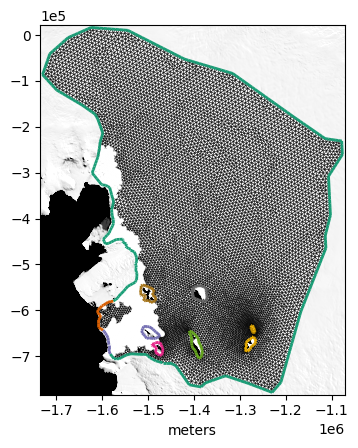

In [3]:
invert_amundsen.plot_mesh()

In [4]:
invert_amundsen.import_velocity_data(constant_val=0.01)

Reading velocity from measures database
C0 is constant: 0.01
Defining friction law


In [ ]:
invert_amundsen.import_geophysics_data(name_list=['data/geophysics/ADMAP_2S_epsg3031_gdal.tif', 
                                                'data/geophysics/ANTGG_BouguerAnomaly_10km_MF_combined_2.tif', # interpolated using multifidelity modeling
                                                'data/geophysics/GeothermalHeatFlux_5km.tif',
                                                'data/geophysics/ALBMAP_SurfaceAirTemperature_5km.tif',
                                                'data/geophysics/AntGG2021_Gravity_disturbance_at-surface_grav_dist.tif',
                                                'data/geophysics/ALBMAP_SnowAccumulation_Arthern_5km.tif',
                                                'data/geophysics/Englacial_temp_Pattyn_2013.tif',
                                                'data/geophysics/bed_class_oct29_2025.tif'])

Defining friction law
using englacial temperature for rate factor
Geophysics data imported


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Englacial Temperature'}, xlabel='meters'>)

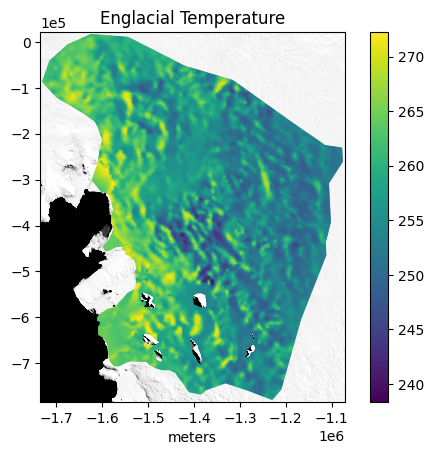

In [8]:
invert_amundsen.plot_englacial_temp()

In [ ]:
invert_amundsen.invert_C(max_iterations=200, regularization_grad_fcn= True, loss_fcn_type = 'nosigma')

Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.634803e+08   9.215758e+03                  2.394417e+04   
  1     1.257310e+08   3.610559e+03   2.394417e+04   5.986044e+04   3         2         0         1         3         
  2     2.817503e+07   1.063957e+03   5.986044e+04   1.496511e+05   4         3         0         3         2         
Optimization Terminated with Status: Iteration Limit Exceeded


In [7]:
u_optimized =  invert_amundsen.simulation()

In [ ]:
firedrake.assemble(invert_amundsen.loss_functional_nosigma(u_optimized))
# 200 iter: 2450.364047776876

2450.364047776876

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='UPS x [m]', ylabel='UPS y [m]'>)

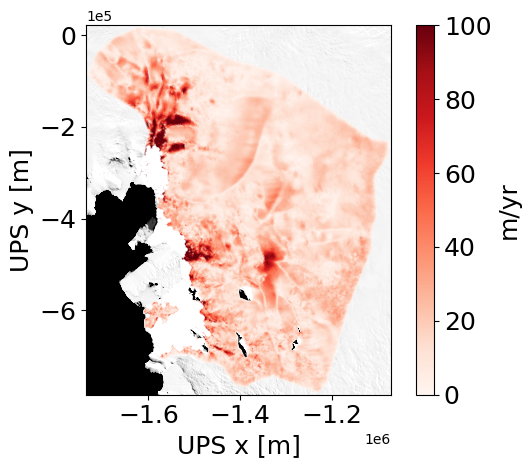

In [10]:
invert_amundsen.plot_u_error_no_sigma(u_optimized, vmax = 100)

In [17]:
def plot_C_obj(obj, vmin=-2, vmax=3, title=False):
    """Plot C (standalone version)."""
    fig, axes = obj.plot_bounded_antarctica()
    axes.set_xlabel("UPS x [m]", fontsize=18)
    axes.tick_params(axis='x', labelsize=18)
    axes.tick_params(axis='y', labelsize=18)

    colors = firedrake.tripcolor(obj.C, axes=axes)
    colors.set_clim(vmin, vmax)  # Set color limits on the ScalarMappable

    cbar = fig.colorbar(colors)
    #cbar.set_label("C", fontsize=18)
    cbar.ax.tick_params(labelsize=18)

    # Overlay white dots over floating ice (no label)
    phi = obj.get_phi(obj.h, obj.s)
    Q_temp = firedrake.FunctionSpace(obj.mesh, family="CG", degree=1)
    line = firedrake.interpolate(phi, Q_temp)
    phi_values = line.dat.data[:]
    x = line.function_space().mesh().coordinates.dat.data[:, 0]
    y = line.function_space().mesh().coordinates.dat.data[:, 1]
    x_coords = x[(phi_values <= 0.1 + 0.01)]
    y_coords = y[(phi_values <= 0.1 + 0.01)]
    if len(x_coords) > 0:
        axes.scatter(x_coords, y_coords, color='white', s=7)
    if title:
        axes.set_title("C")
    return fig, axes

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='UPS x [m]'>)

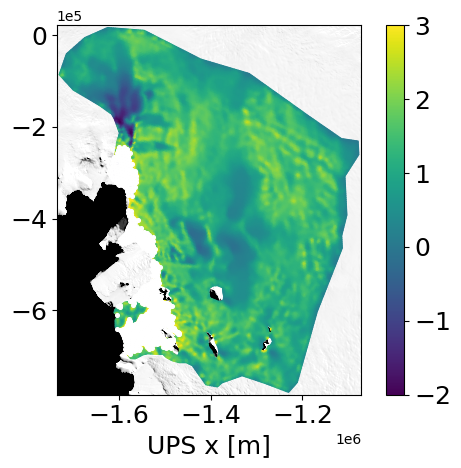

In [18]:
plot_C_obj(invert_amundsen, title = False, vmin = -2, vmax =3 )

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '% Error in U'}, xlabel='meters'>)

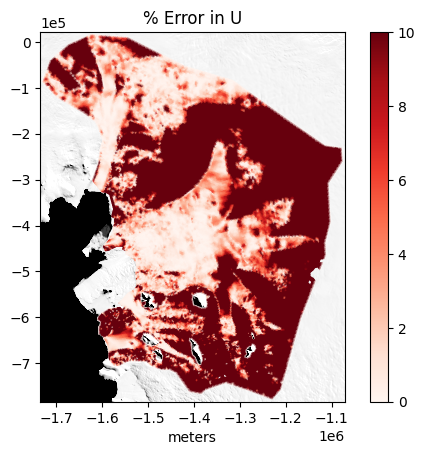

In [11]:
invert_amundsen.plot_u_error_percentage(u_optimized, vmax = 10)

In [12]:
C_optimized = invert_amundsen.get_C()

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='UPS x [m]'>)

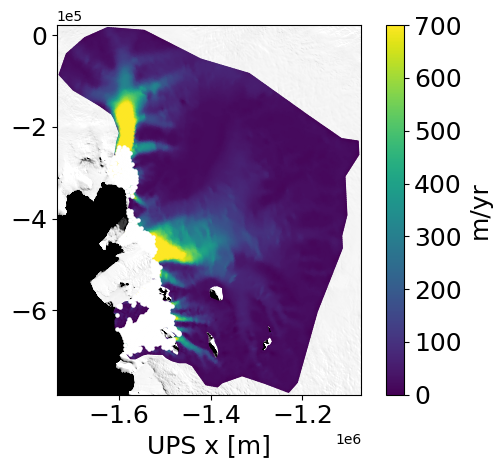

In [13]:
invert_amundsen.plot_u_mag(u_optimized, vmax=700)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'C'}, xlabel='UPS x [m]'>)

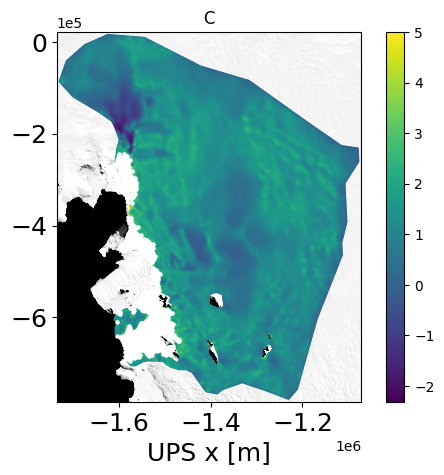

In [14]:
invert_amundsen.plot_C(vmax = 5)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': '$C_{b}$'}, xlabel='meters'>)

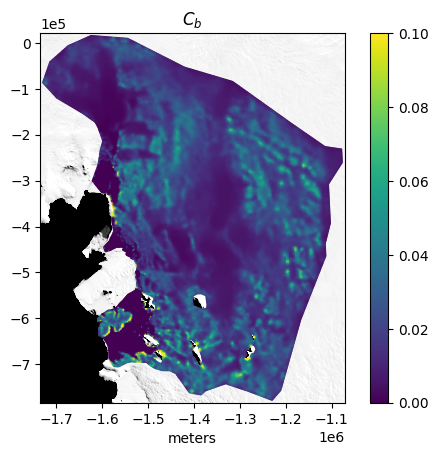

In [15]:
invert_amundsen.plot_C_total(vmax = 0.1)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Grounding Line'}, xlabel='meters'>)

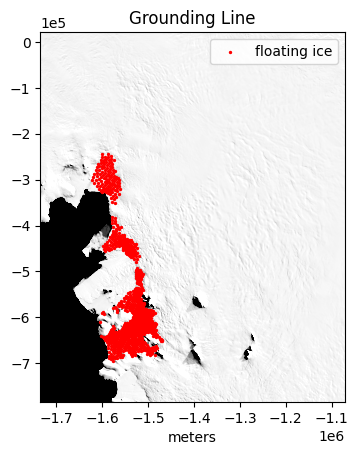

In [16]:
invert_amundsen.plot_grounding_line()

In [8]:
#invert_dotson.inverse_u = invert_dotson.u_initial
invert_amundsen.inverse_u = u_optimized

In [ ]:
#theta = invert_dotson.θ
C = invert_amundsen.C

In [9]:
df = invert_amundsen.get_dataframe(u_optimized)
df.to_csv('regularized_const_01C_C_only_englacial_temp_amundsen_r005_geo_12_bed_class_updated_geo.csv')

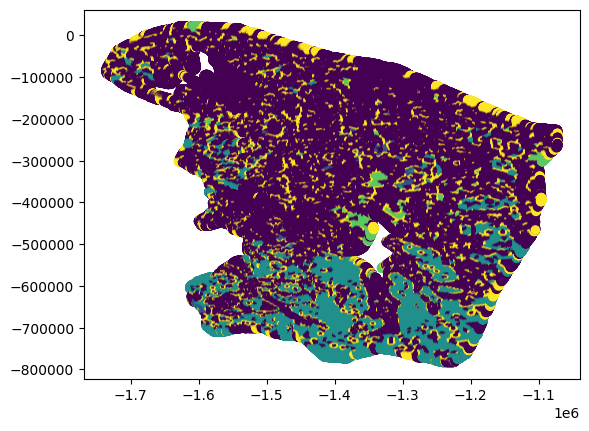

In [13]:
plt.scatter(df['x'], df['y'], c=df['bed_class'], cmap='viridis', vmin=0, vmax=4)